In [1]:
# Imports
import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

#import logging
#log = logging.getLogger(__name__)

try:
    import covid19_inference as cov19
    print("Option 1")
except ModuleNotFoundError:
    sys.path.append("../")
    import covid19_inference as cov19
    print("Option 2")

Option 2


# Dallas County

In [57]:
# Read in case data
cases = pd.read_csv("CaseData.csv")
dallas = cases[cases["County Name"] == "Dallas"]
dallas = dallas.set_index("Date")
dallas = dallas[["Cases"]]
dallas.index = pd.to_datetime(dallas.index)
dallas.head(20)

,Cases
Date,
2020-03-04,0.0
2020-03-05,0.0
2020-03-06,0.0
2020-03-09,0.0
2020-03-10,0.0
2020-03-11,2.0
2020-03-12,3.0
2020-03-13,3.0
2020-03-15,8.0


In [58]:
dallas = dallas[20:]

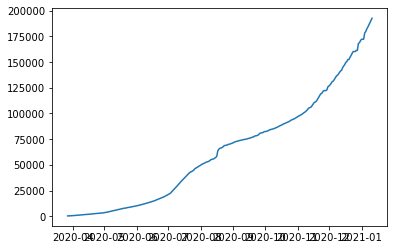

In [59]:
plt.plot(dallas.index, dallas["Cases"])
plt.show()

In [60]:
# Fix for any holes
dmin = min(dallas.index)
dmax = max(dallas.index)

idx = pd.date_range(dmin, dmax)
dallas = dallas.reindex(idx)
dallas = dallas.sort_index()

In [61]:
# Calculate daily new cases
new_cases_obs = dallas.diff()
new_cases_obs = new_cases_obs.dropna()

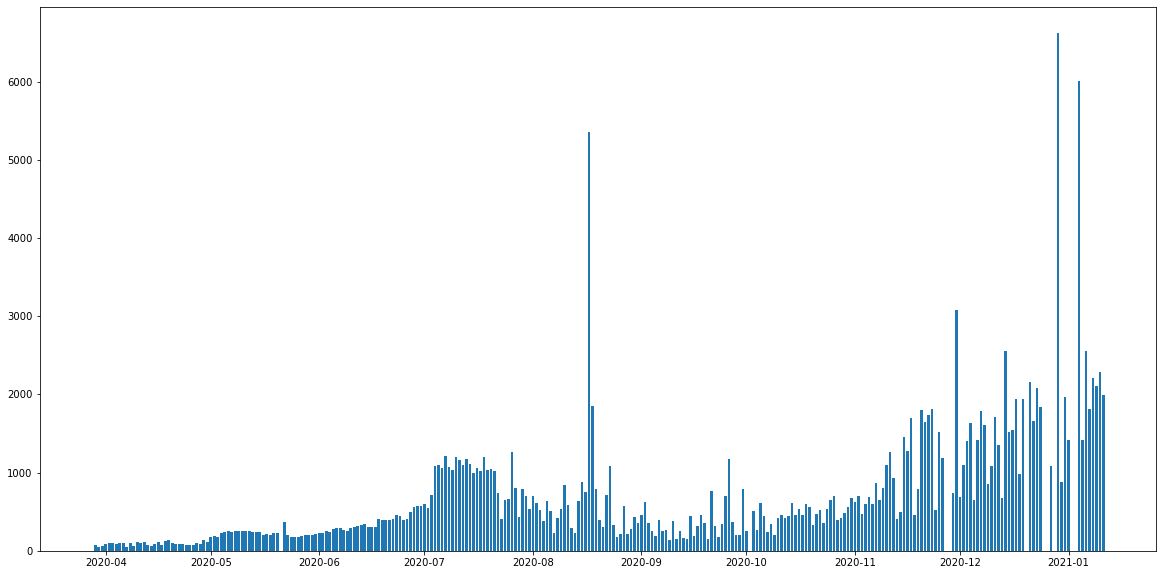

In [62]:
plt.figure(figsize=(20,10))
plt.bar(new_cases_obs.index, new_cases_obs["Cases"])
plt.show()

In [63]:
# Setup params
diff_data_sim = 16
num_days_forecast = 10
pr_delay = 10
pr_len_scale = 7.0
#pr_len_scale = 7.0 # Length scale for the GP

# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=dmin,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=2630000,
)

# Put model together
with cov19.model.Cov19Model(**params_model) as this_model:

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
    
    # Create the array of the time dependent infection rate lambda
    #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
    pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
    lambda_t_log = cov19.model.lambda_t_gp(
                        mu,
                        pr_len_scale,
                        pr_amplitude,
                        #model=None,
                        name_lambda_t="lambda_t",
    )

    # This builds a decorrelated prior for I_begin for faster inference.
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [64]:
# Full inference takes a while to run, so start with just the MAP
with this_model:
    maps = pm.find_MAP()

In [52]:
maps.keys()

dict_keys(['mu_log__', 'pr_amplitude_interval__', 'log_r_t_rotated_', 'I_begin_ratio_log', 'delay_hc_sigma_log__', 'delay_hc_L1_log', 'delay_hc_L2_log_raw_', 'sigma_weekend_factor_log__', 'weekend_factor_hc_L1_log', 'weekend_factor_hc_L2_log_raw_', 'offset_modulation_rad_circular__', 'sigma_obs_log__', 'mu', 'pr_amplitude', 'log_r_t', 'r_t', 'log_lambda_t', 'lambda_t', 'I_begin', 'new_I_t', 'S_t', 'I_t', 'delay_hc_sigma', 'delay_hc_L2_log', 'delay_hc_L2', 'delay_hc_L1', 'delayed_cases', 'sigma_weekend_factor', 'weekend_factor_hc_L2_log', 'weekend_factor_hc_L1', 'weekend_factor_hc_L2', 'offset_modulation_rad', 'offset_modulation', 'new_cases', 'sigma_obs'])

In [65]:
print("GP:")
#print("Length scale = {}".format(maps["pr_len_scale"]))
print("Amplitude = {}".format(maps["pr_amplitude"]))

GP:
Amplitude = 0.699615268580083


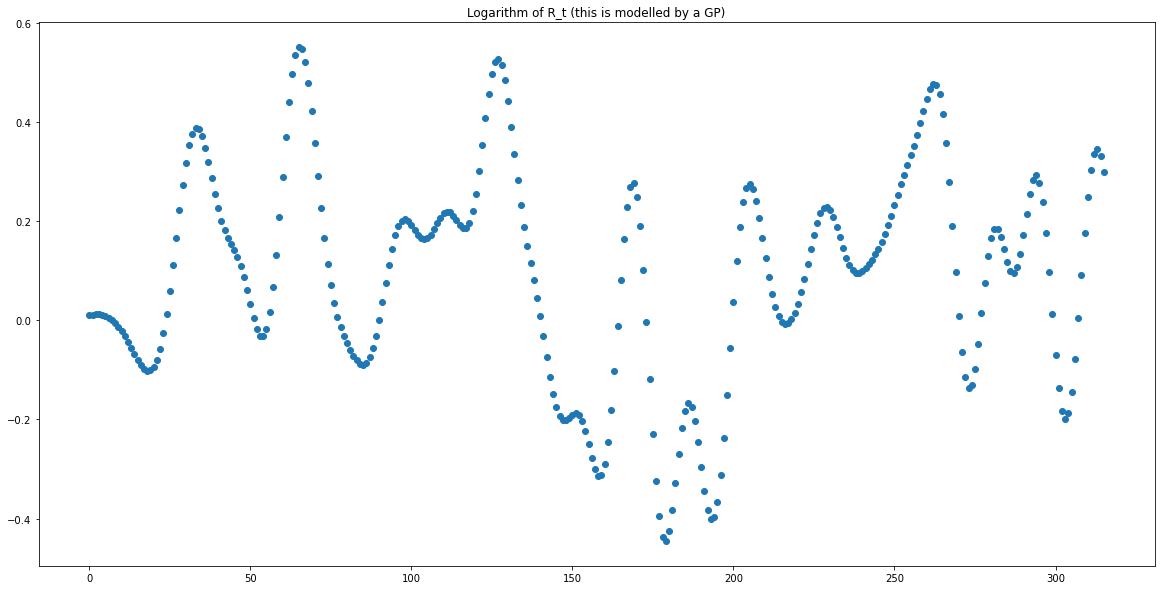

In [66]:
plt.figure(figsize=(20,10))
plt.scatter([j for j in range(len(maps['log_r_t']))], maps['log_r_t'])
plt.title("Logarithm of R_t (this is modelled by a GP)")
plt.show()

(0.0, 2.0)

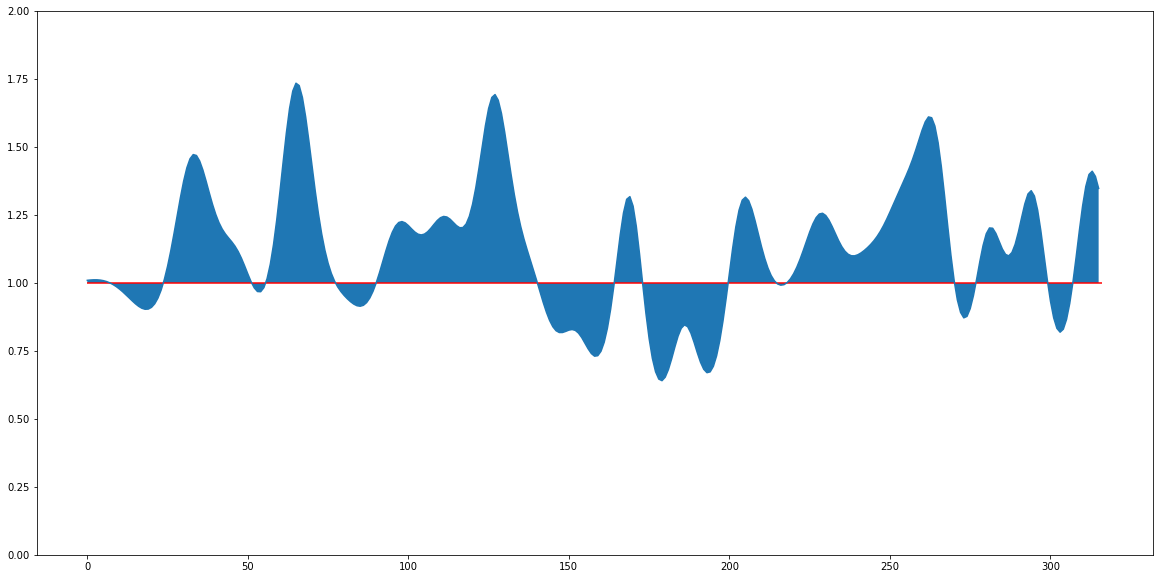

In [67]:
plt.figure(figsize=(20,10))
plt.plot([j for j in range(len(maps['r_t']))], maps['r_t'])
plt.fill_between([j for j in range(len(maps['r_t']))], np.ones(len(maps['r_t'])), maps['r_t'])
plt.hlines(1.0, 0, len(maps['r_t']), color="red", label="R_t = 1.0")
plt.ylim([0.0, 2.0])

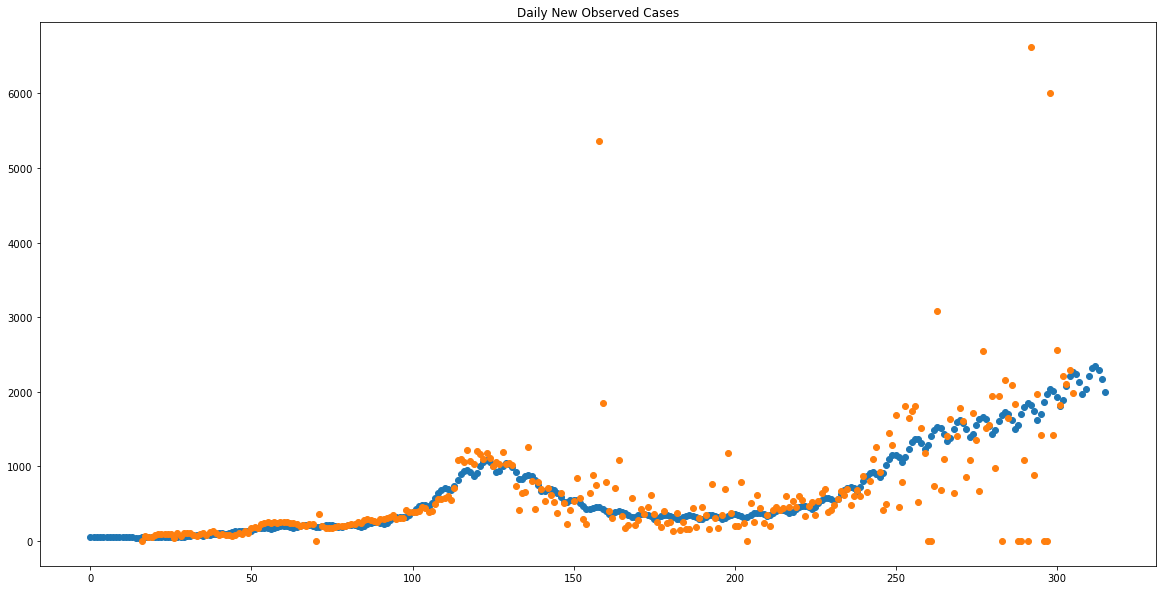

In [56]:
plt.figure(figsize=(20,10))
plt.scatter([j for j in range(len(maps['new_cases']))], maps['new_cases'])
plt.scatter([j+diff_data_sim for j in range(len(new_cases_obs))], new_cases_obs)
plt.title("Daily New Observed Cases")
plt.show()

# Texas Curve

In [68]:
cases = pd.read_csv("CaseData.csv")
texas = cases[cases["County Name"] == "Dallas"]
texas = texas.set_index("Date")
texas = texas[["Cases"]]
texas.index = pd.to_datetime(texas.index)
texas.head()

,Cases
Date,
2020-03-04,0.0
2020-03-05,0.0
2020-03-06,0.0
2020-03-09,0.0
2020-03-10,0.0


In [69]:
texas = texas[20:]

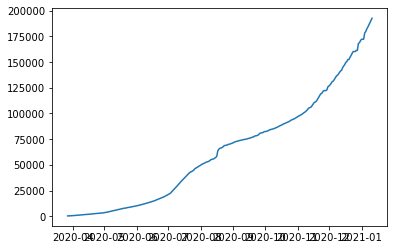

In [70]:
plt.plot(texas.index, texas["Cases"])
plt.show()

In [71]:
# Fix for any holes
tmin = min(texas.index)
tmax = max(texas.index)

idx = pd.date_range(tmin, tmax)
texas = texas.reindex(idx)
texas = texas.sort_index()

In [72]:
# Calculate daily new cases
new_cases_obs = texas.diff()
new_cases_obs = new_cases_obs.dropna()

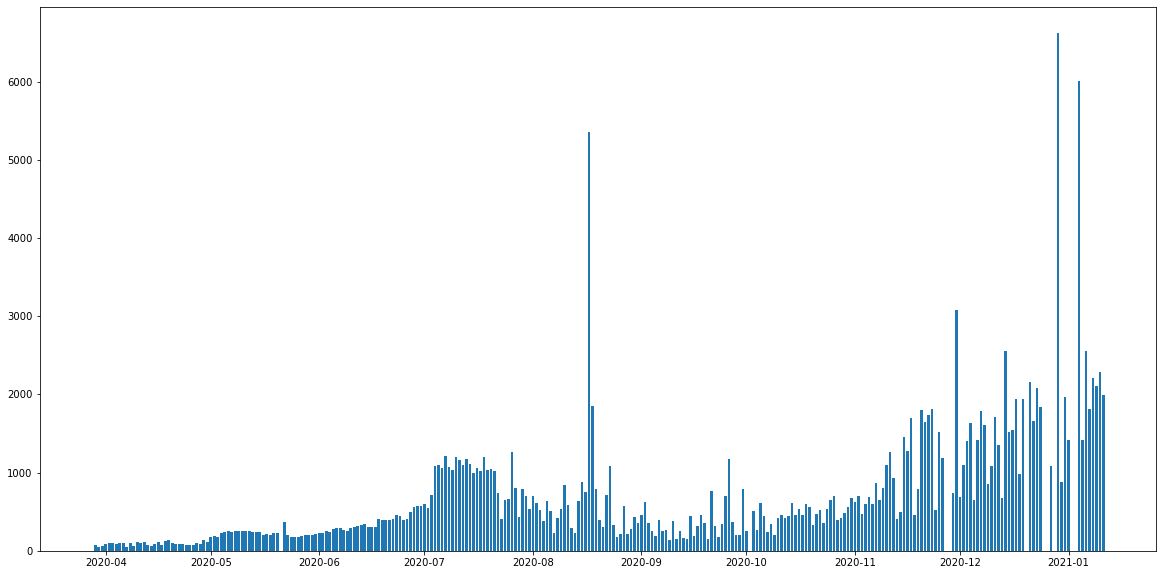

In [73]:
plt.figure(figsize=(20,10))
plt.bar(new_cases_obs.index, new_cases_obs["Cases"])
plt.show()

In [74]:
# Setup params
diff_data_sim = 16
num_days_forecast = 10
pr_delay = 10
pr_len_scale = 7.0
#pr_len_scale = 7.0 # Length scale for the GP

# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=dmin,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=29000000,
)

# Put model together
with cov19.model.Cov19Model(**params_model) as tx_model:

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
    
    # Create the array of the time dependent infection rate lambda
    #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
    pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
    lambda_t_log = cov19.model.lambda_t_gp(
                        mu,
                        pr_len_scale,
                        pr_amplitude,
                        #model=None,
                        name_lambda_t="lambda_t",
    )

    # This builds a decorrelated prior for I_begin for faster inference.
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [75]:
# Full inference takes a while to run, so start with just the MAP
with tx_model:
    tx_maps = pm.find_MAP()

(0.0, 7.0)

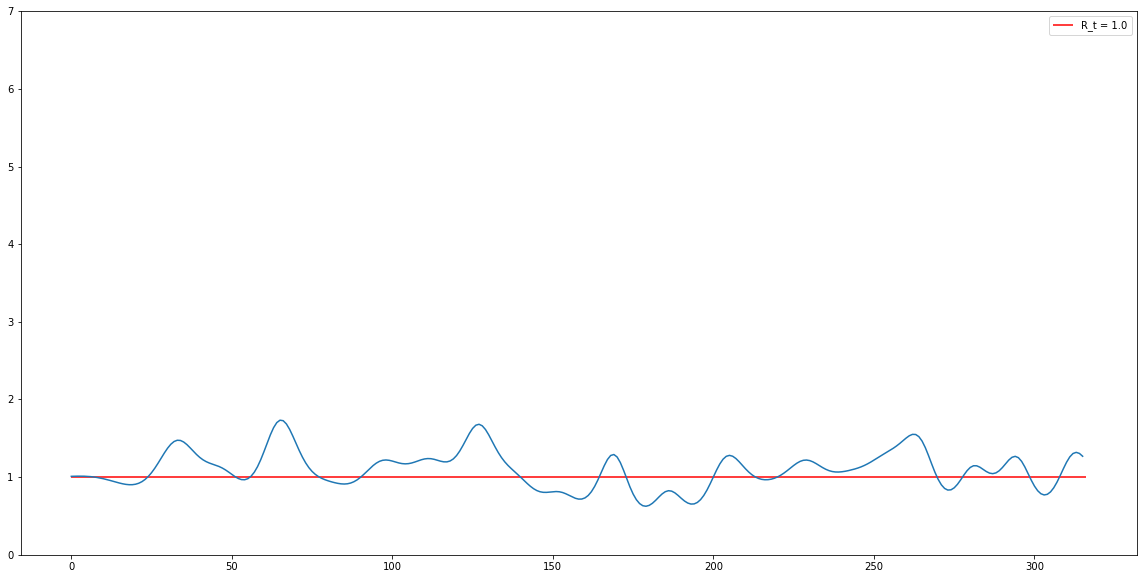

In [76]:
plt.figure(figsize=(20,10))
plt.plot([j for j in range(len(tx_maps['r_t']))], tx_maps['r_t'])

plt.hlines(1.0, 0, len(tx_maps['r_t']), color="red", label="R_t = 1.0")
plt.legend()
plt.ylim([0.0, 7.0])

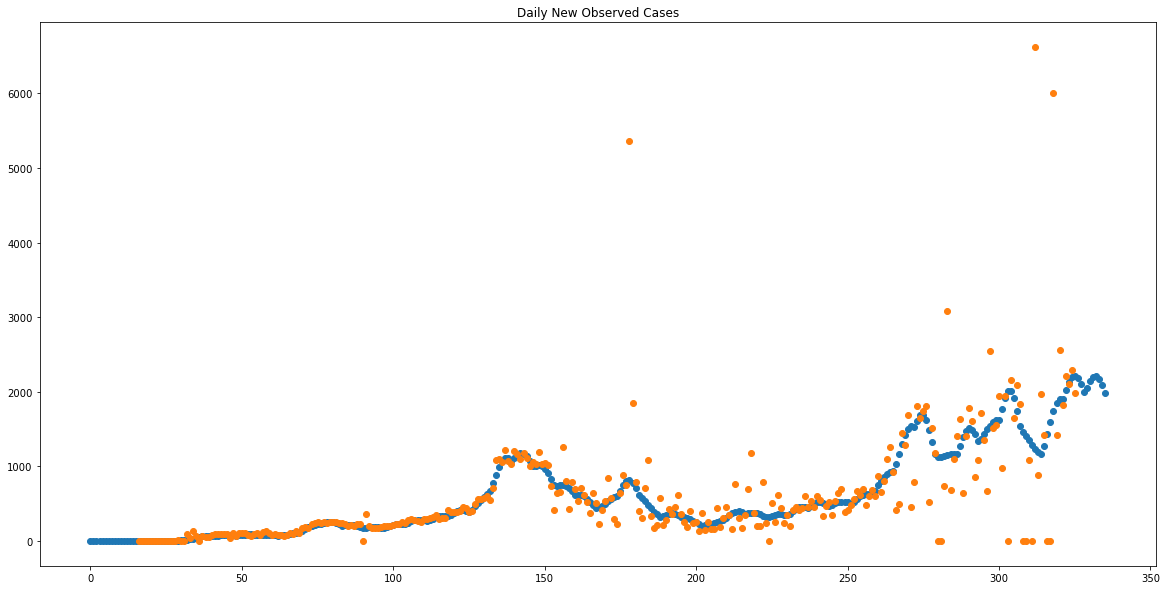

In [41]:
plt.figure(figsize=(20,10))
plt.scatter([j for j in range(len(tx_maps['new_cases']))], tx_maps['new_cases'])
plt.scatter([j+diff_data_sim for j in range(len(new_cases_obs))], new_cases_obs)
plt.title("Daily New Observed Cases")
plt.show()